<a href="https://colab.research.google.com/github/YosefLab/popV/blob/main/tabula_sapiens_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Tabula Sapiens as a reference for annotating new datasets

This notebook allows you to annotate your data with a number of annotation methods using the Tabula Sapiens dataset as the reference.

Initial setup:
1. Make sure GPU is enabled (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU)
2. We also highly recommend getting Colab PRO for access to an extended RAM session.


Integration Methods Provided:
- scVI [(Lopez et al. 2018)](https://www.nature.com/articles/s41592-018-0229-2)
- bbKNN [(Polański et al. 2020)](https://academic.oup.com/bioinformatics/article/36/3/964/5545955)
- Scanorama [(He et al. 2019)](https://www.nature.com/articles/s41587-019-0113-3)
- Harmony [(Korsunsky et al. 2019)](https://www.nature.com/articles/s41592-019-0619-0)

Annotation Methods:
- KNN on integrated spaces
- scANVI [(Xu et al. 2021)](https://www.embopress.org/doi/full/10.15252/msb.20209620)
- onClass [(Wang et al. 2020)](https://www.biorxiv.org/content/10.1101/810234v2)
- Celltypist [(Dominguez Conde et al. 2022)](https://www.science.org/doi/10.1126/science.abl5197)
- SVM
- RandomForest

To use the notebook, simply connect to your Google Drive account, set the necessary arguments, select your methods, and run all the code blocks!

**User action is only required in Steps 1-3.**

Last edited: 08/27/2024



## Step 1: Setup environment

We omit the output of those lines for readability.

In [1]:
%%capture
import os

import pandas as pd
import popv
import scanpy as sc

2025-01-22 11:52:38.614741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737575558.627037 1847821 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737575558.630706 1847821 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Step 2: Load your data (User Action Required)
Here we provide three options to load your data:
1. Connect to Google Drive (highly recommended)
2. Download your data from the cloud and save into this session or on Google drive.
3. Upload your data manually into this session (files are not persistent and will be deleted when session is closed)

As an example, we use a subsampled version of the [Lung Cell Atlas](https://hlca.ds.czbiohub.org/) \[1] for our query data.

\[1] Travaglini, K. et al. A molecular cell atlas of the human lung from single-cell RNA sequencing. *Nature* **587**, 619–625(2020).

In [36]:
input_file = {
    "source": "cellxgene",
    "path": "tmp/lung_transplant.h5ad",
    "url": "https://cellxgene.cziscience.com/e/429d21fd-bb9a-4abf-922b-c15138524bdd.cxg/",
}

input_file = {
    "source": "cellxgene",
    "path": "tmp/lung_map.h5ad",
    "url": "https://cellxgene.cziscience.com/e/3de0ad6d-4378-4f62-b37b-ec0b75a50d94.cxg/",
}

input_file = {
    "source": "cellxgene",
    "path": "tmp/LCA.h5ad",
    "url": "https://cellxgene.cziscience.com/e/8c42cfd0-0b0a-46d5-910c-fc833d83c45e.cxg/",
}
os.makedirs(os.path.dirname(input_file["path"]), exist_ok=True)

if input_file["source"] == "gdrive":
    # OPTION 1: Connect to Google Drive.
    from google.colab import drive

    drive.mount("/content/drive")
    query_adata = sc.read(input_file["path"])
elif input_file["source"] == "cellxgene":
    # OPTION 2: Download from CELLxGENE URL.
    import cellxgene_census

    try:  # CELLxGENE throws error if file exists.
        cellxgene_census.download_source_h5ad(
            dataset_id=input_file["url"].rsplit("/", 2)[1].rsplit(".")[0],
            census_version="stable",
            to_path=input_file["path"],
        )
    except ValueError:
        pass
    query_adata = sc.read_h5ad(input_file["path"])
else:
    query_adata = sc.read(input_file["path"], backup_url=input_file["url"])

query_adata.obs_names_make_unique()
# Downsample to reduce RAM usage. Not necessary with Google Colab Pro.
sc.pp.subsample(query_adata, 0.2)

In [37]:
query_adata.X = query_adata.raw.X

In [38]:
query_adata.X.data

array([1., 2., 1., ..., 1., 4., 1.], dtype=float32)

## Step 3 (User Action Required): Setting Up Annotation Parameters

Here is where you set the parameters for the automated annotation.

Arguments:
- **huggingface_repo:** Reference model to use. See hugingface for further information (https://huggingface.co/popV).
- **save_location:** location to save results to. By default will save to a folder named `annotation_results`. It is highly recommended you provide a Google Drive folder here.
- **query_batch_key:** key in `query_adata.obs` for batch correction. Set to None for no batch correction.
- **algorithms:** these are the methods to run. By default, will run all methods provided for the reference data.
Options: ["knn_on_scvi_pred", "scanvi_pred", "knn_on_bbknn_pred", "svm_pred", "rf_pred", "onclass_pred", "knn_on_scanorama_pred".

In [39]:
huggingface_repo = "popV/tabula_sapiens_Endothelium"
query_batch_key = "donor_id"
algorithms = None

## Step 4: Perform annotation
No more user input required! Just run all the following code blocks.

**NOTE: PopV has only been evaluated with the Lung/Thymus/Lymph_Node as a reference dataset. Different tissues have different annotation quality and the Tabula sapiens community is currently actively improving the annotation quality. We strongly expect improvement of cell annotation when the updated annotation is released. Upon release the Zenodo repository will be updated.**

In [20]:
hmo = popv.hub.HubModel.pull_from_huggingface_hub(huggingface_repo, cache_dir="tmp/tabula_sapiens_")
adata = hmo.annotate_data(
    query_adata,
    query_batch_key=query_batch_key,
    prediction_mode="inference",  # "fast"
    # gene_symbols="feature_name", # "Uncomment if using gene symbols."
)

Fetching 21 files:  10%|▉         | 2/21 [00:00<00:07,  2.51it/s]

Fetching 6 files: 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]


LLLLLL tmp/tabula_sapiens_/models--popV--tabula_sapiens_Endothelium/snapshots/910bb038a6a7d90bd668e60b2d3dc4edd05aff76 ['preprocessing.json', 'accuracies.json', 'OnClass.meta', 'xgboost_classifier.model', 'OnClass.npz', 'metadata.json', 'scvi', 'README.md', 'minified_ref_adata.h5ad', 'scanvi', 'OnClass.data-00000-of-00001', 'OnClass.index', 'scvi_knn_classifier.joblib', 'celltypist.pkl', 'pynndescent_index.joblib', 'checkpoint', 'popv_output', 'svm_classifier_cuml.joblib', '.gitattributes', 'obo_dag.joblib', 'harmony_knn_classifier.joblib']
INFO     Found 61.0% reference vars in query data.                                                                 


KeyboardInterrupt: 

In [11]:
# Optional: save the full anndata will all objects
# adata.write(f'{output_folder}/query_and_reference_popv.h5ad')

In [12]:
cell_types = pd.unique(adata.obs[list(adata.uns["prediction_keys"]) + ["cell_type"]].values.ravel("K"))
palette = sc.plotting.palettes.default_102
celltype_colors = dict(zip(list(cell_types), palette, strict=False))

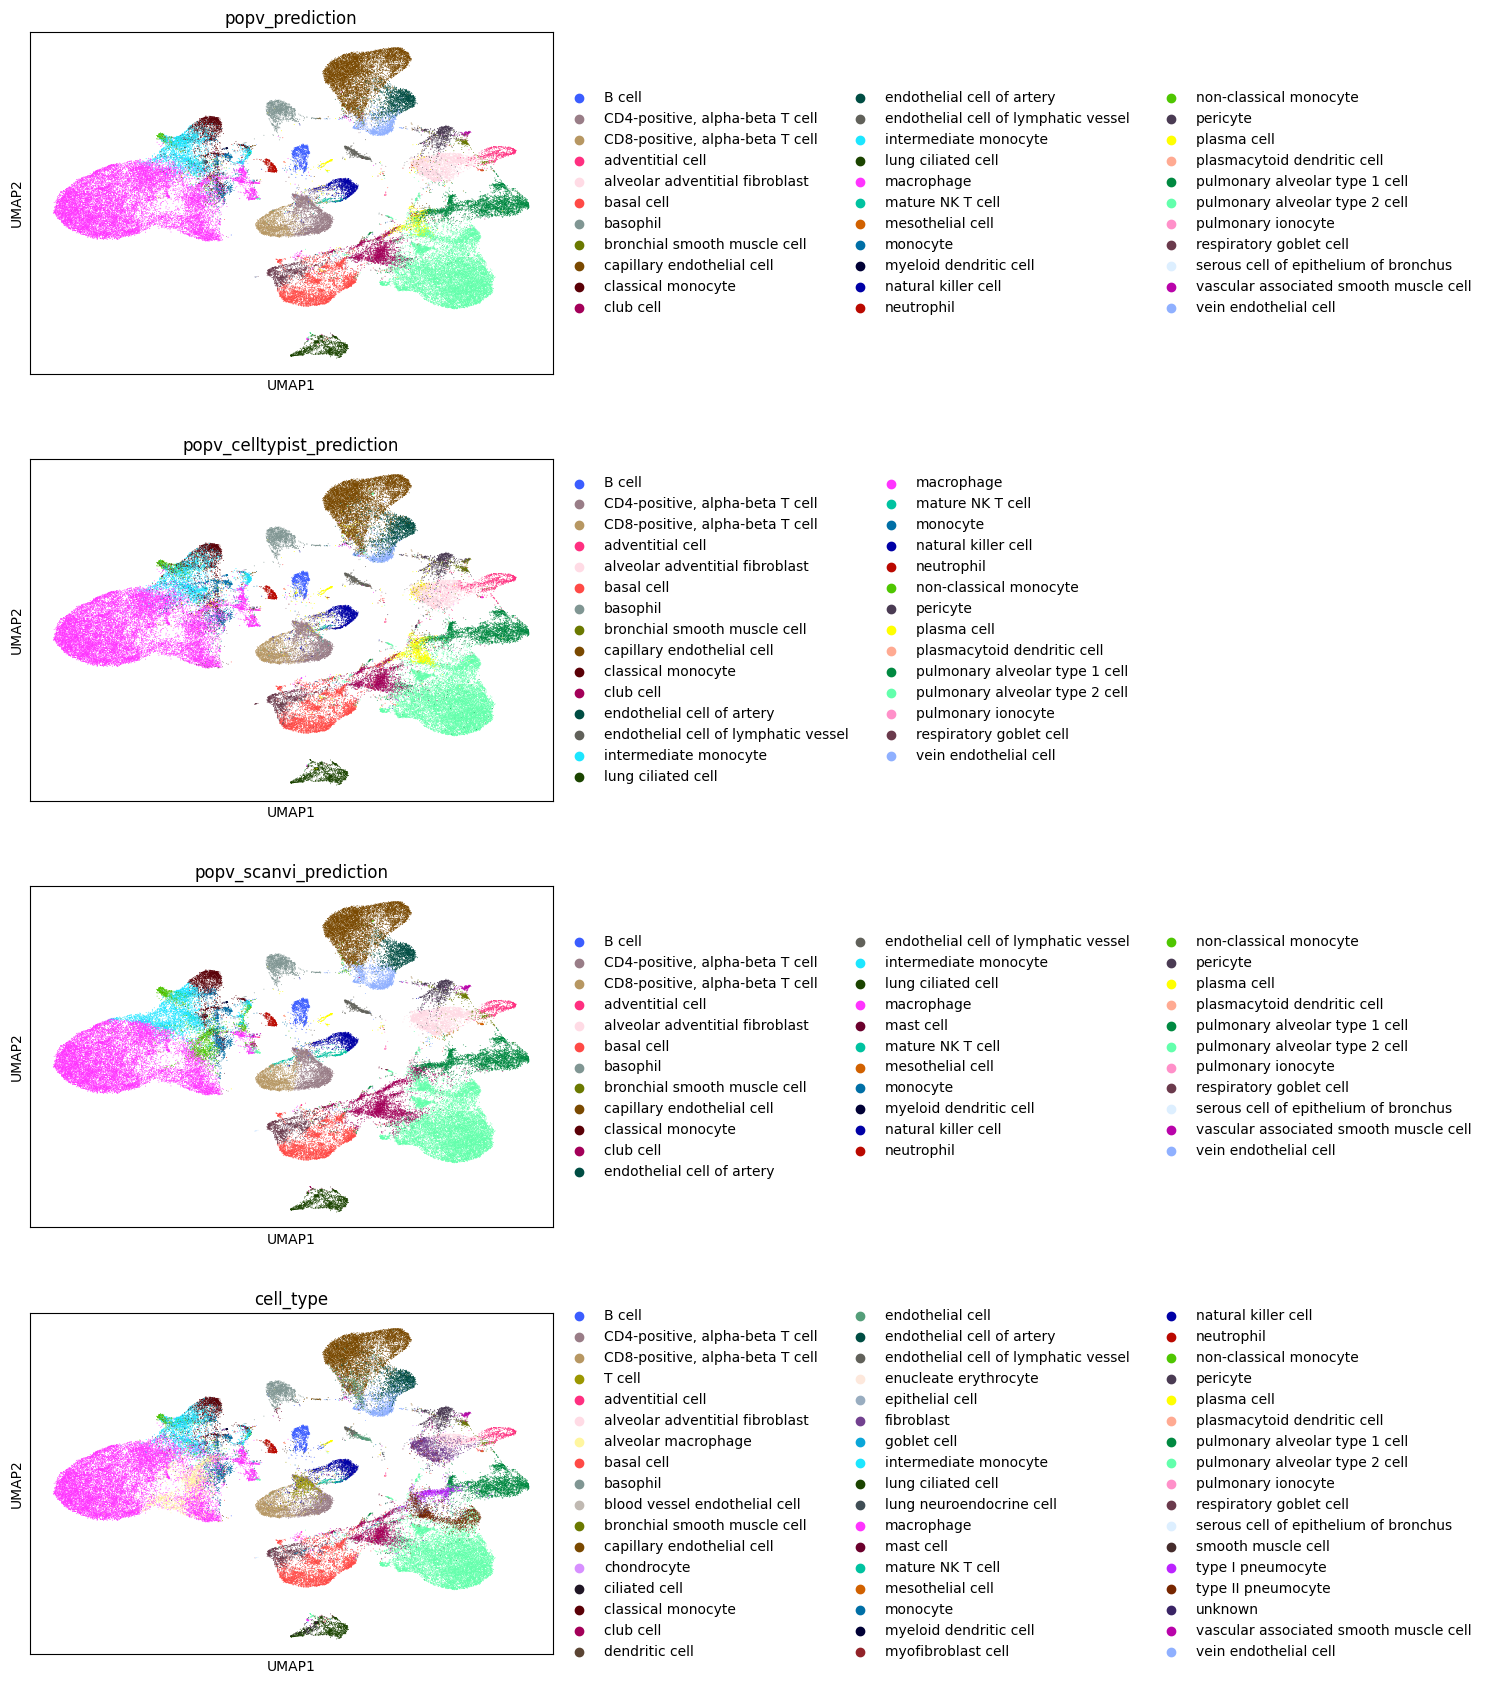

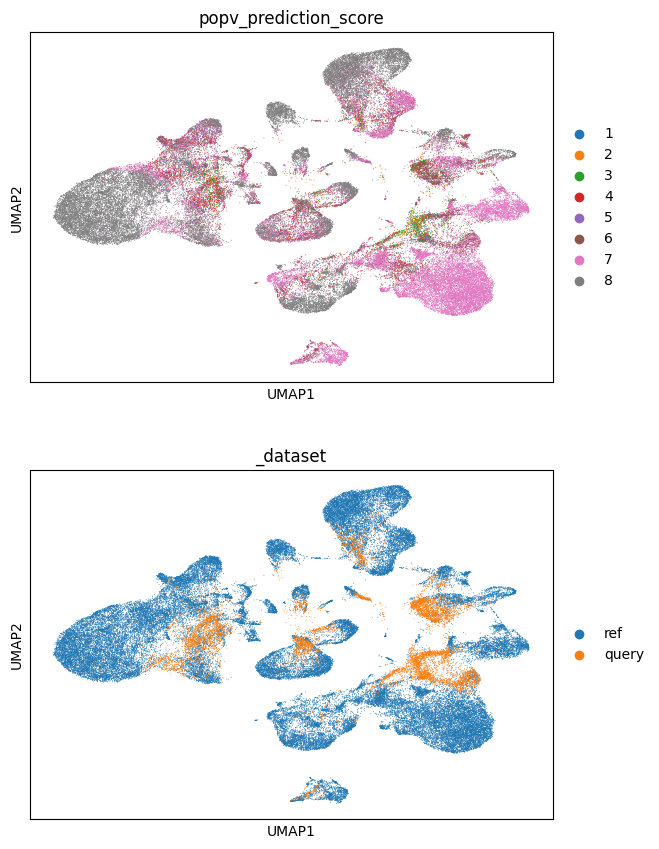

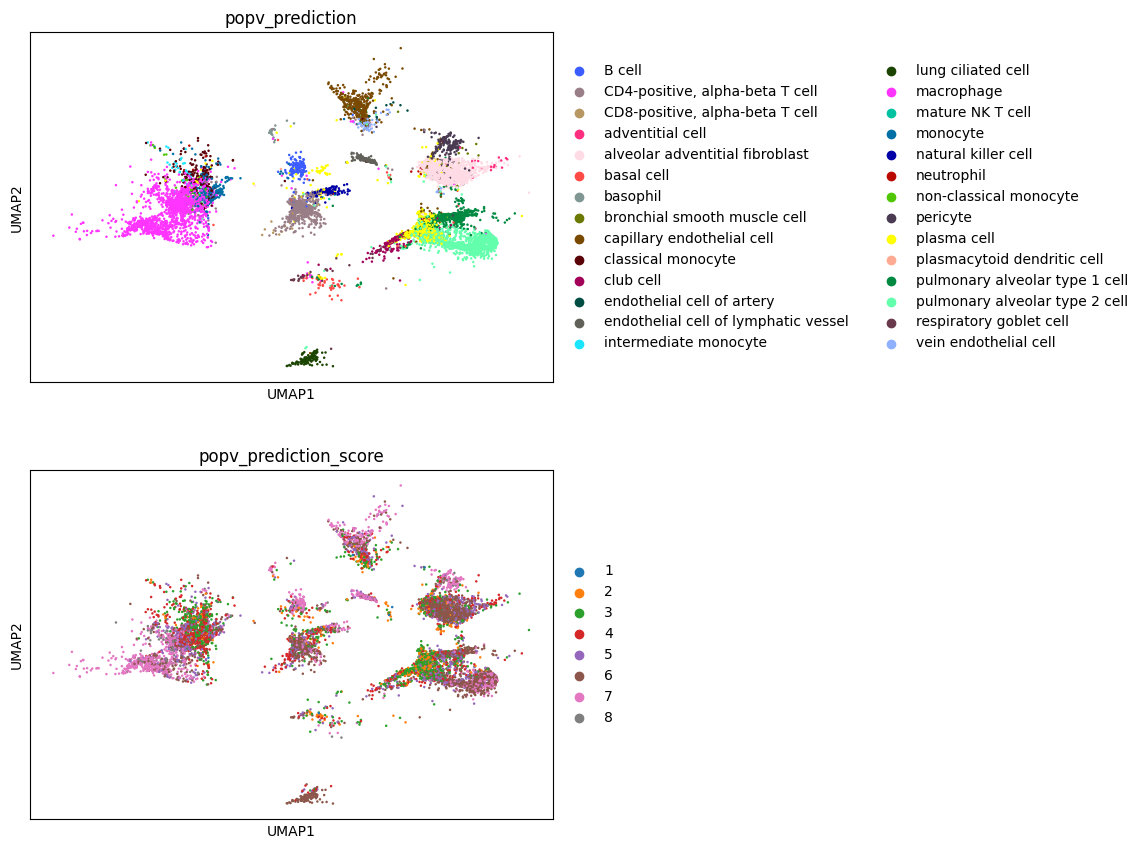

In [15]:
adata.obsm["X_umap"] = adata.obsm["X_umap_scanvi_popv"]

sc.pl.umap(
    adata,
    color=[
        "popv_prediction",
        "popv_celltypist_prediction",
        "popv_scanvi_prediction",
        "cell_type",
    ],
    palette=celltype_colors,
    ncols=1,
)

sc.pl.umap(
    adata,
    color=["popv_prediction_score", "_dataset"],
    ncols=1,
)

sc.pl.umap(
    adata[adata.obs["_dataset"] == "query"],
    color=[
        "popv_prediction",
        "popv_prediction_score",
    ],
    ncols=1,
)

## Step 6: Summary Statistics

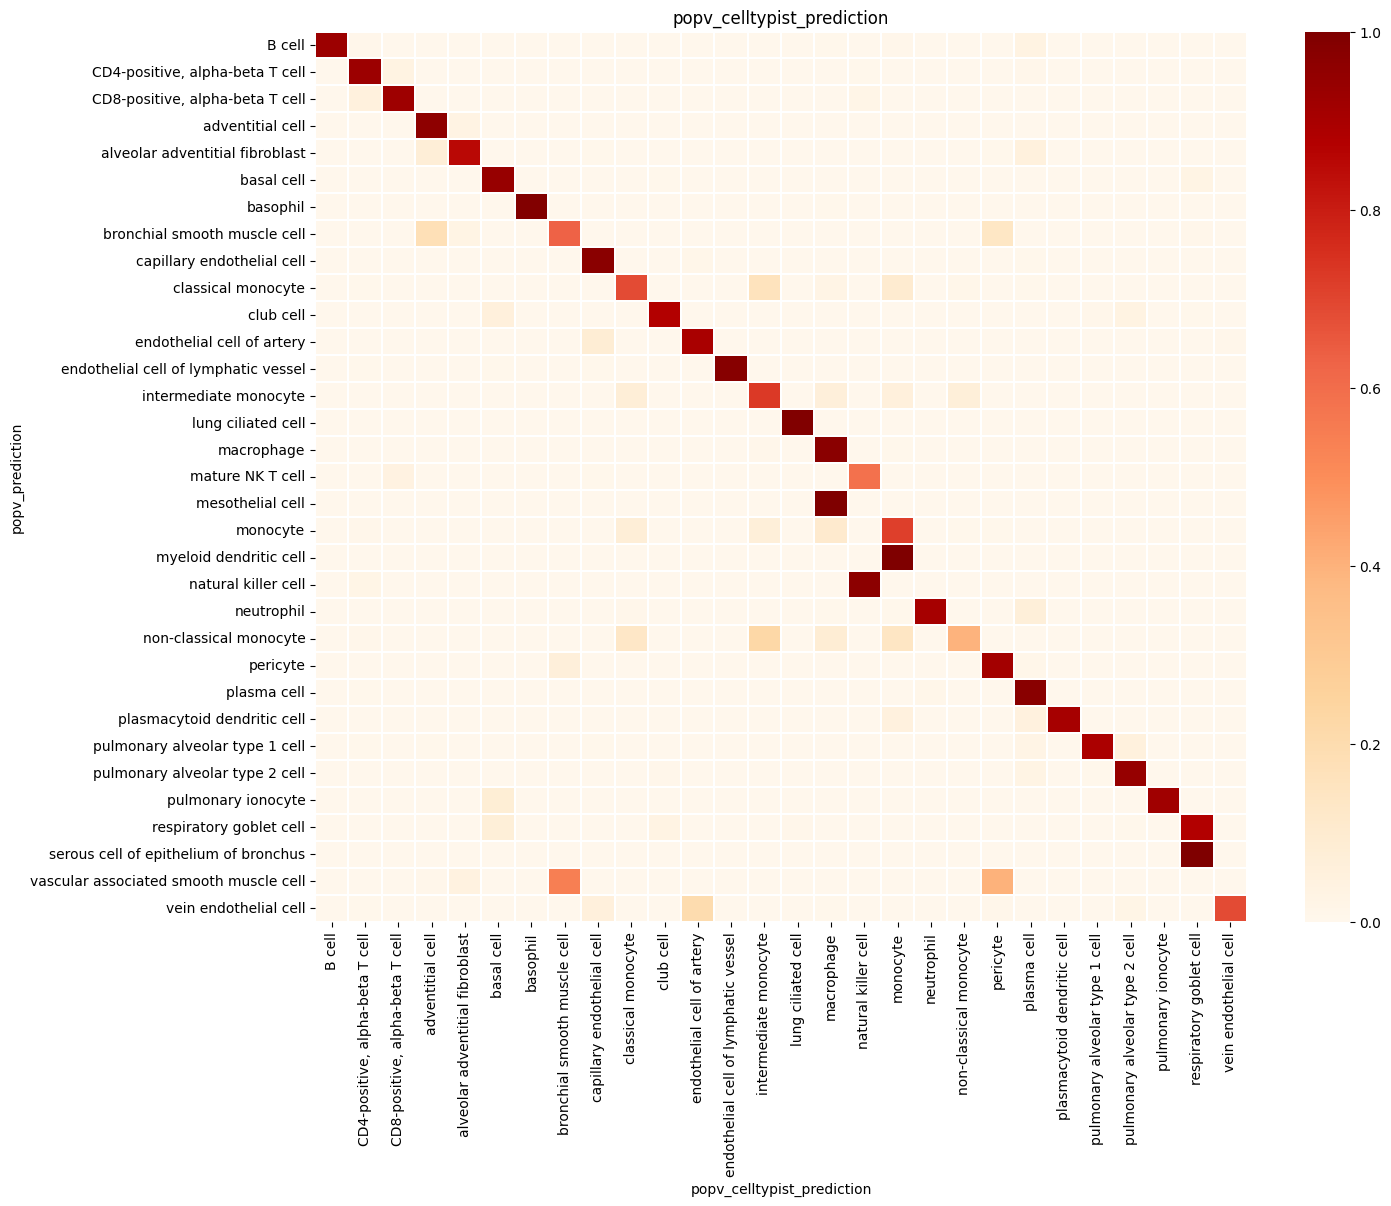

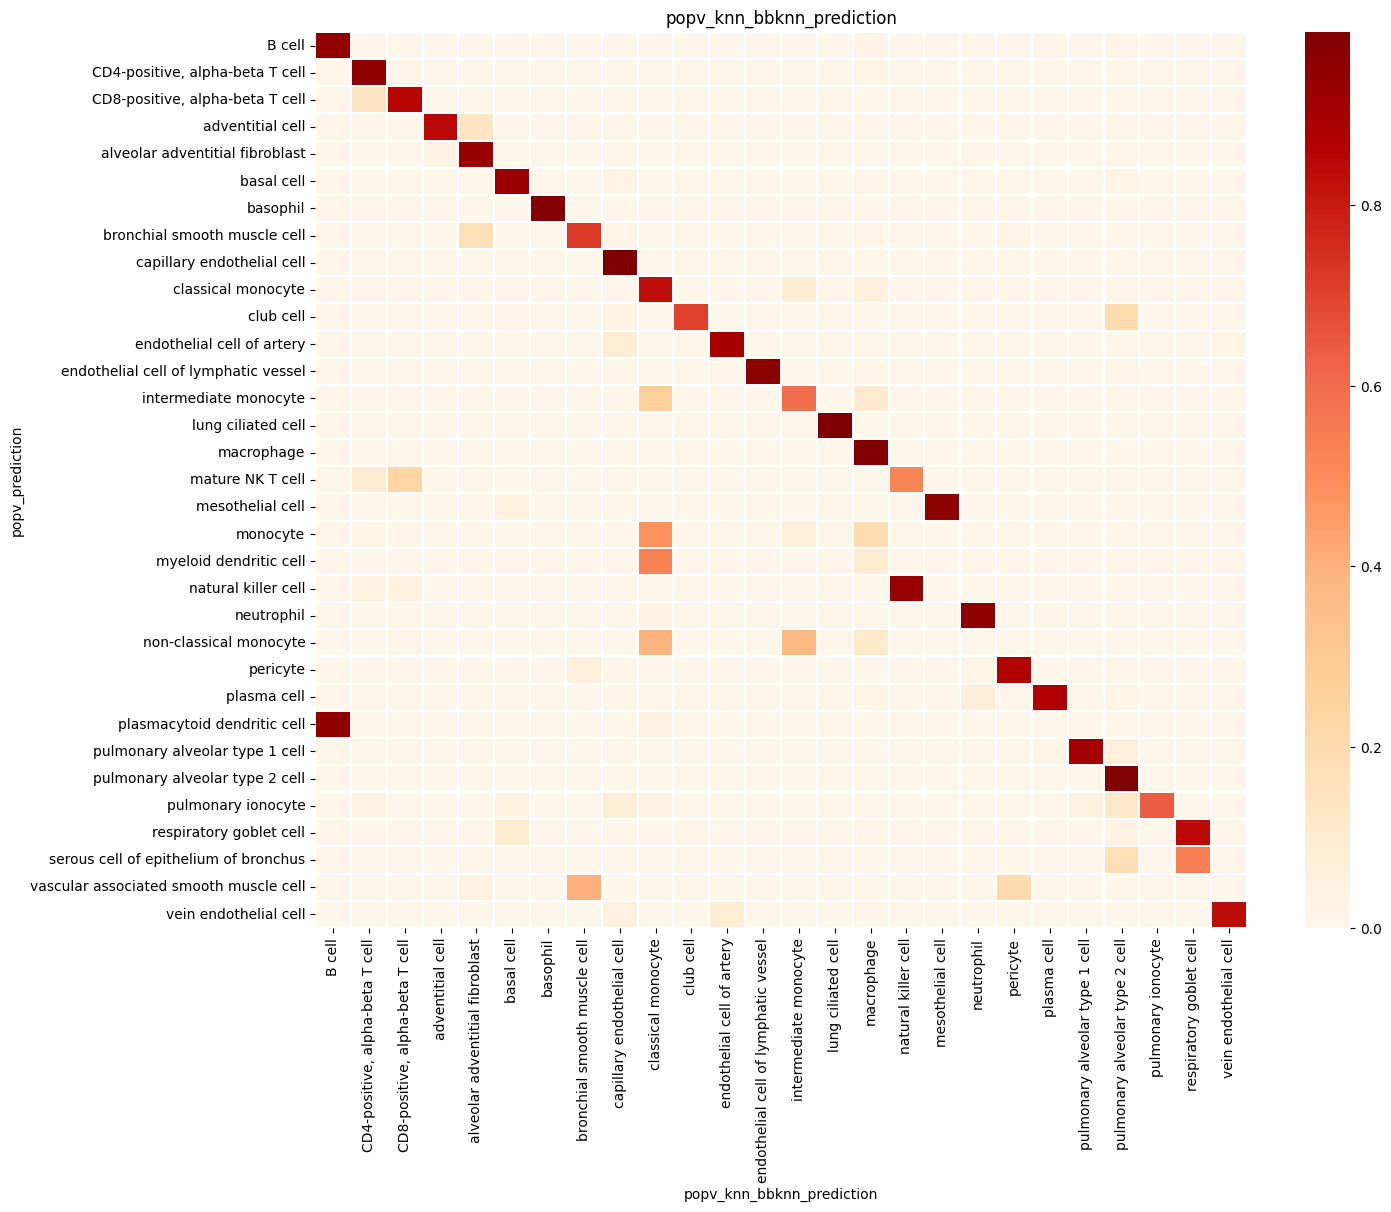

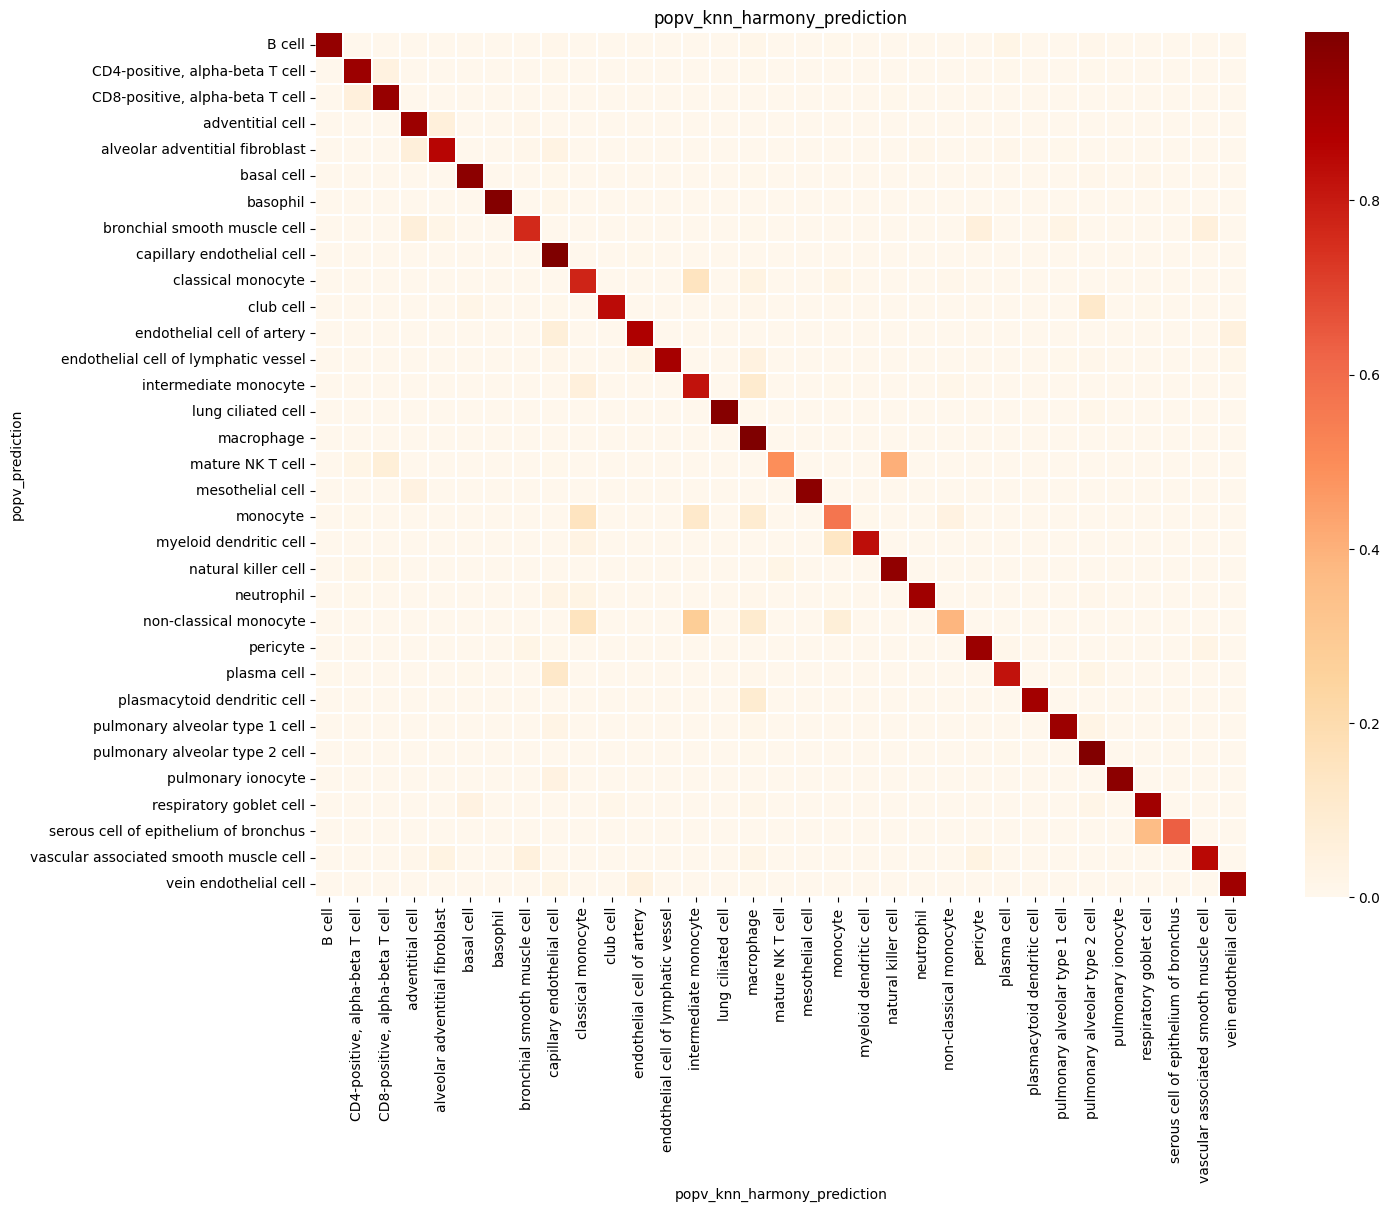

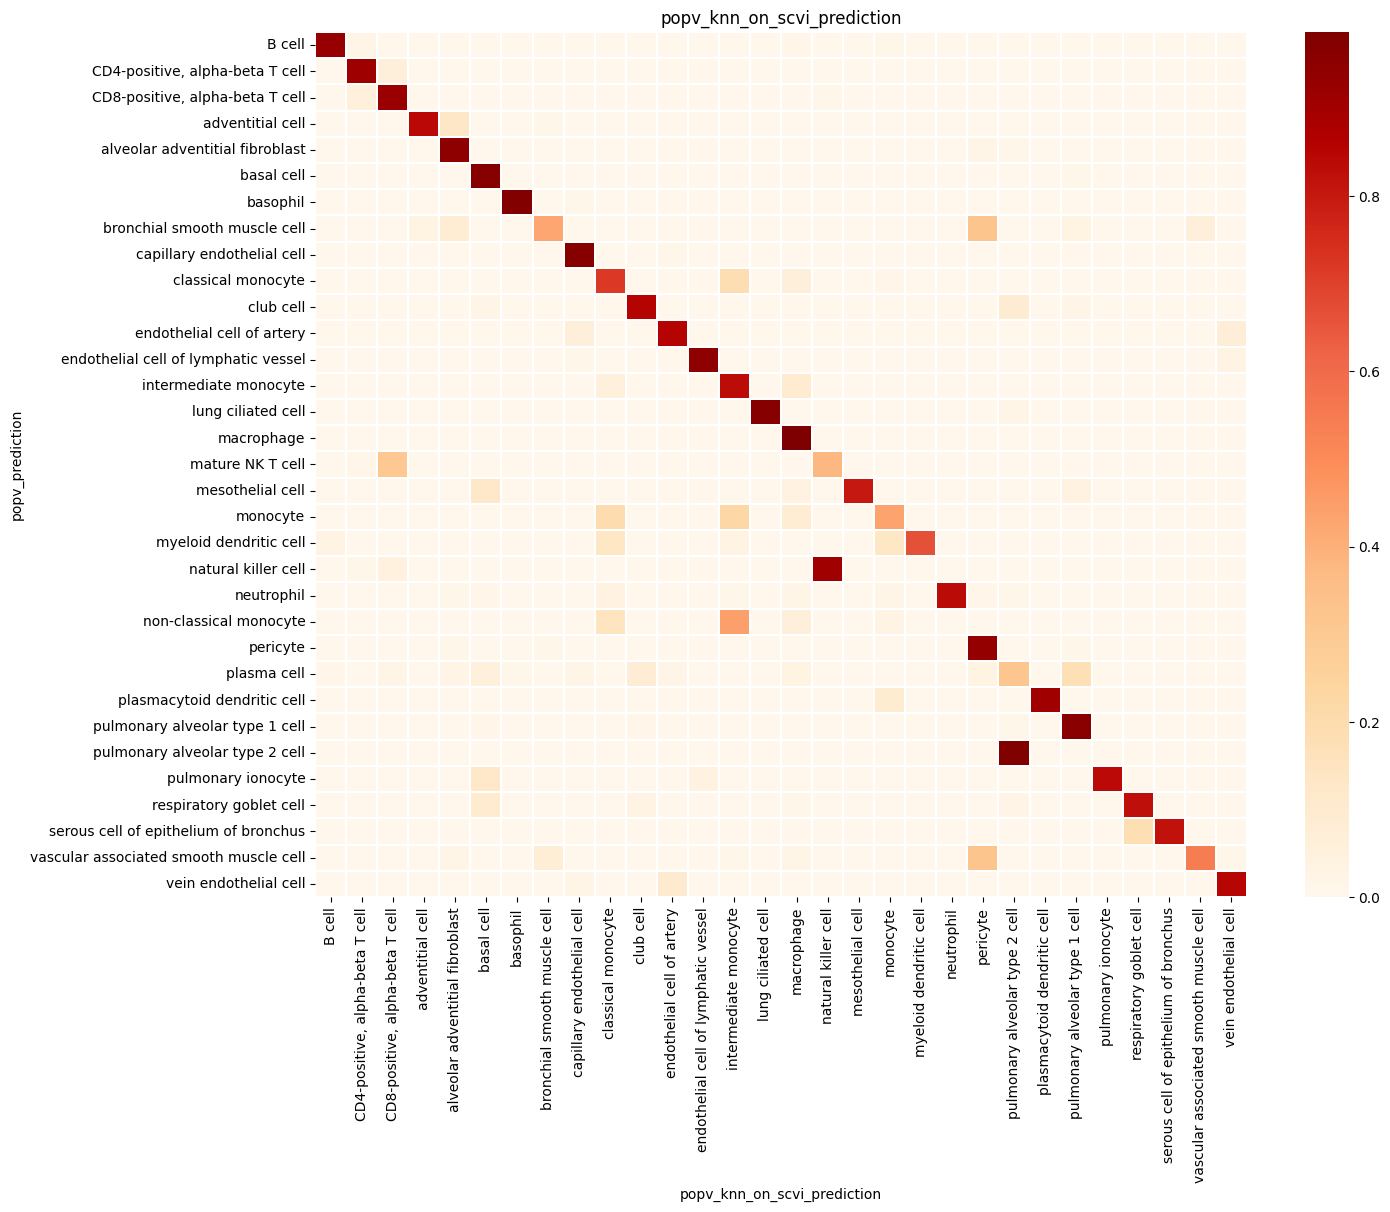

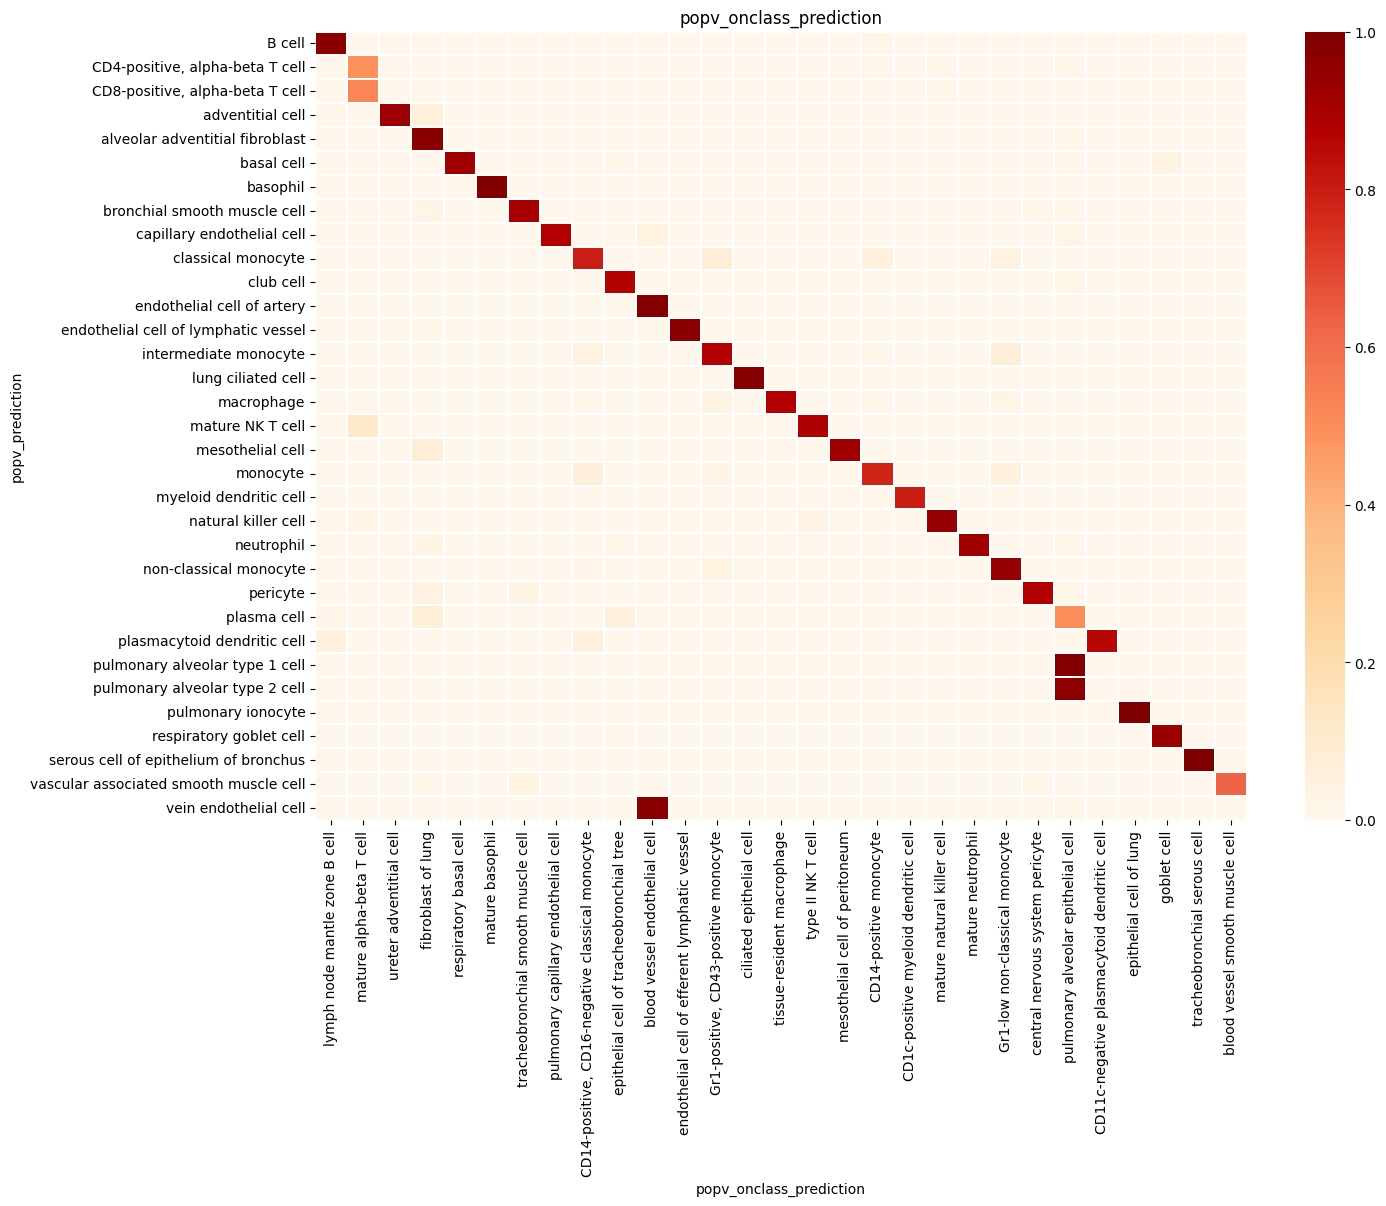

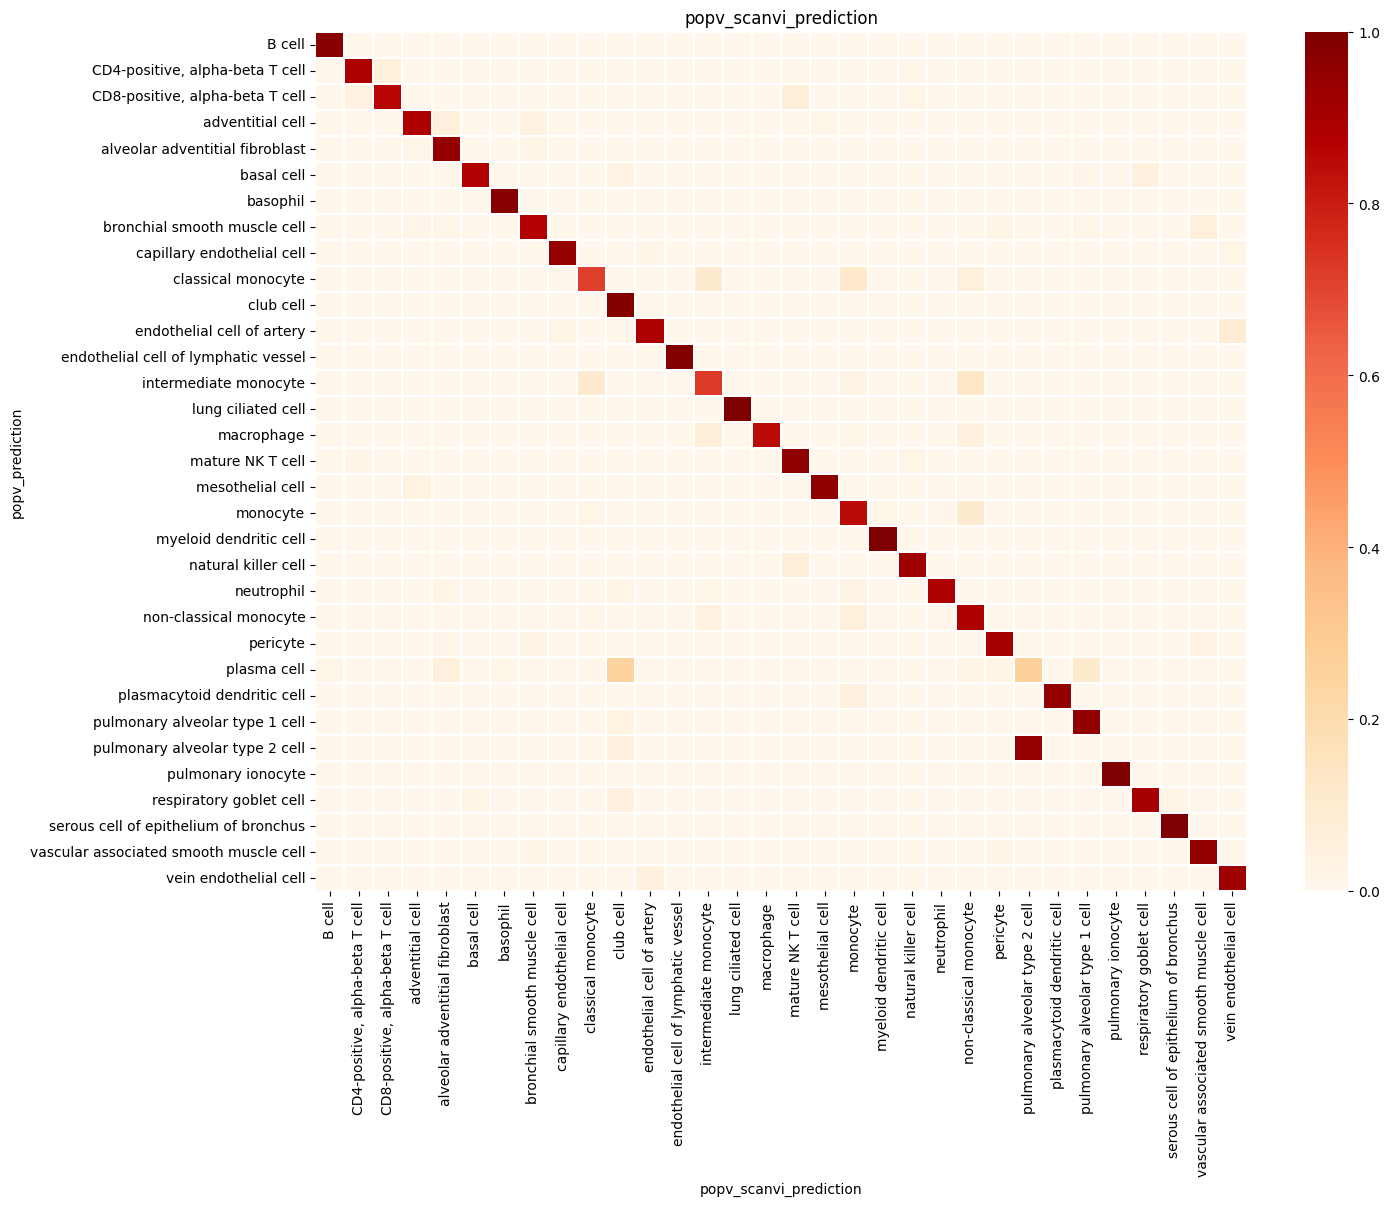

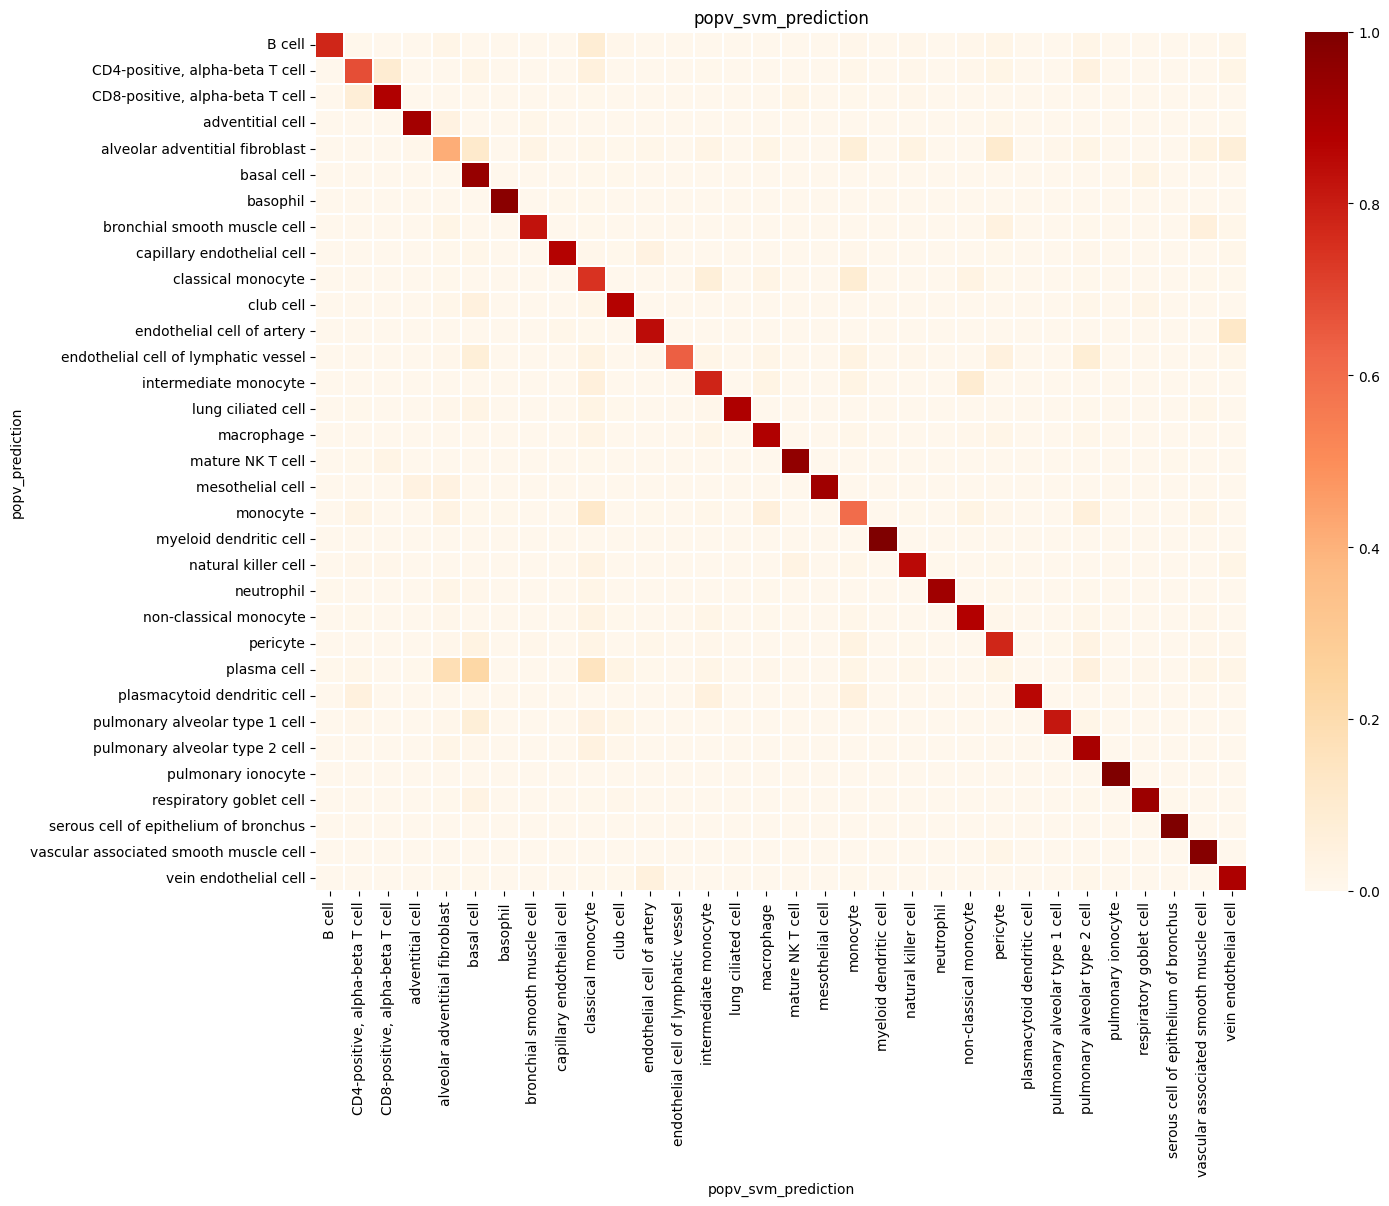

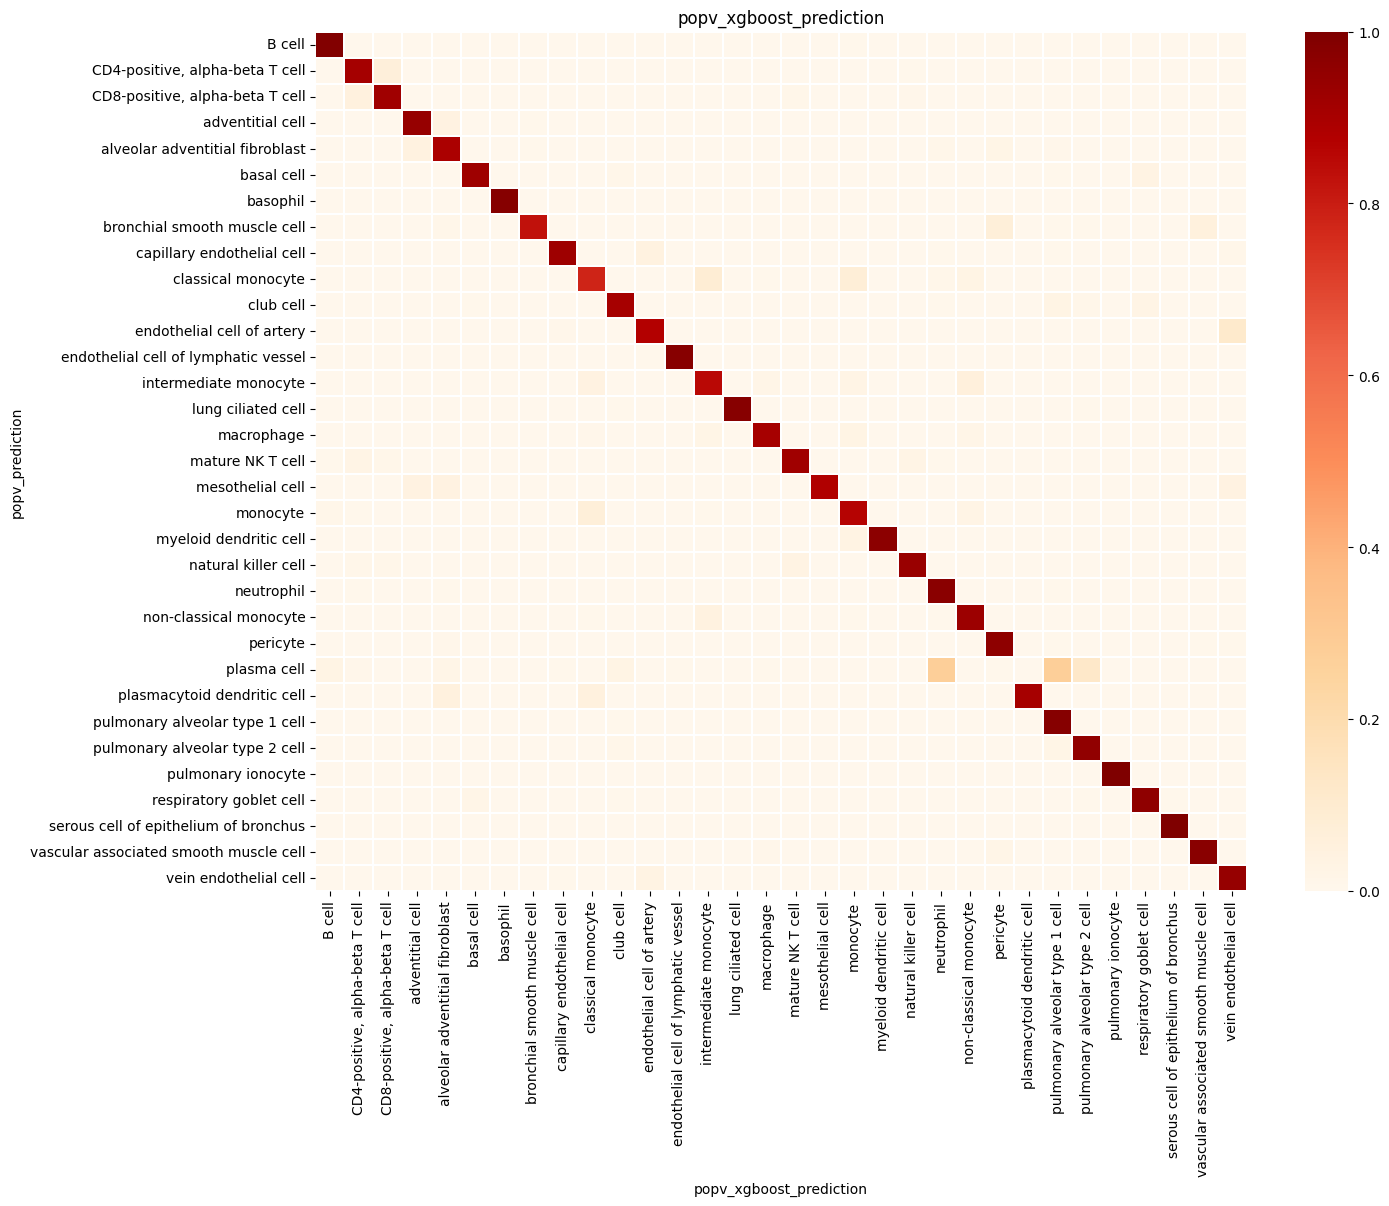

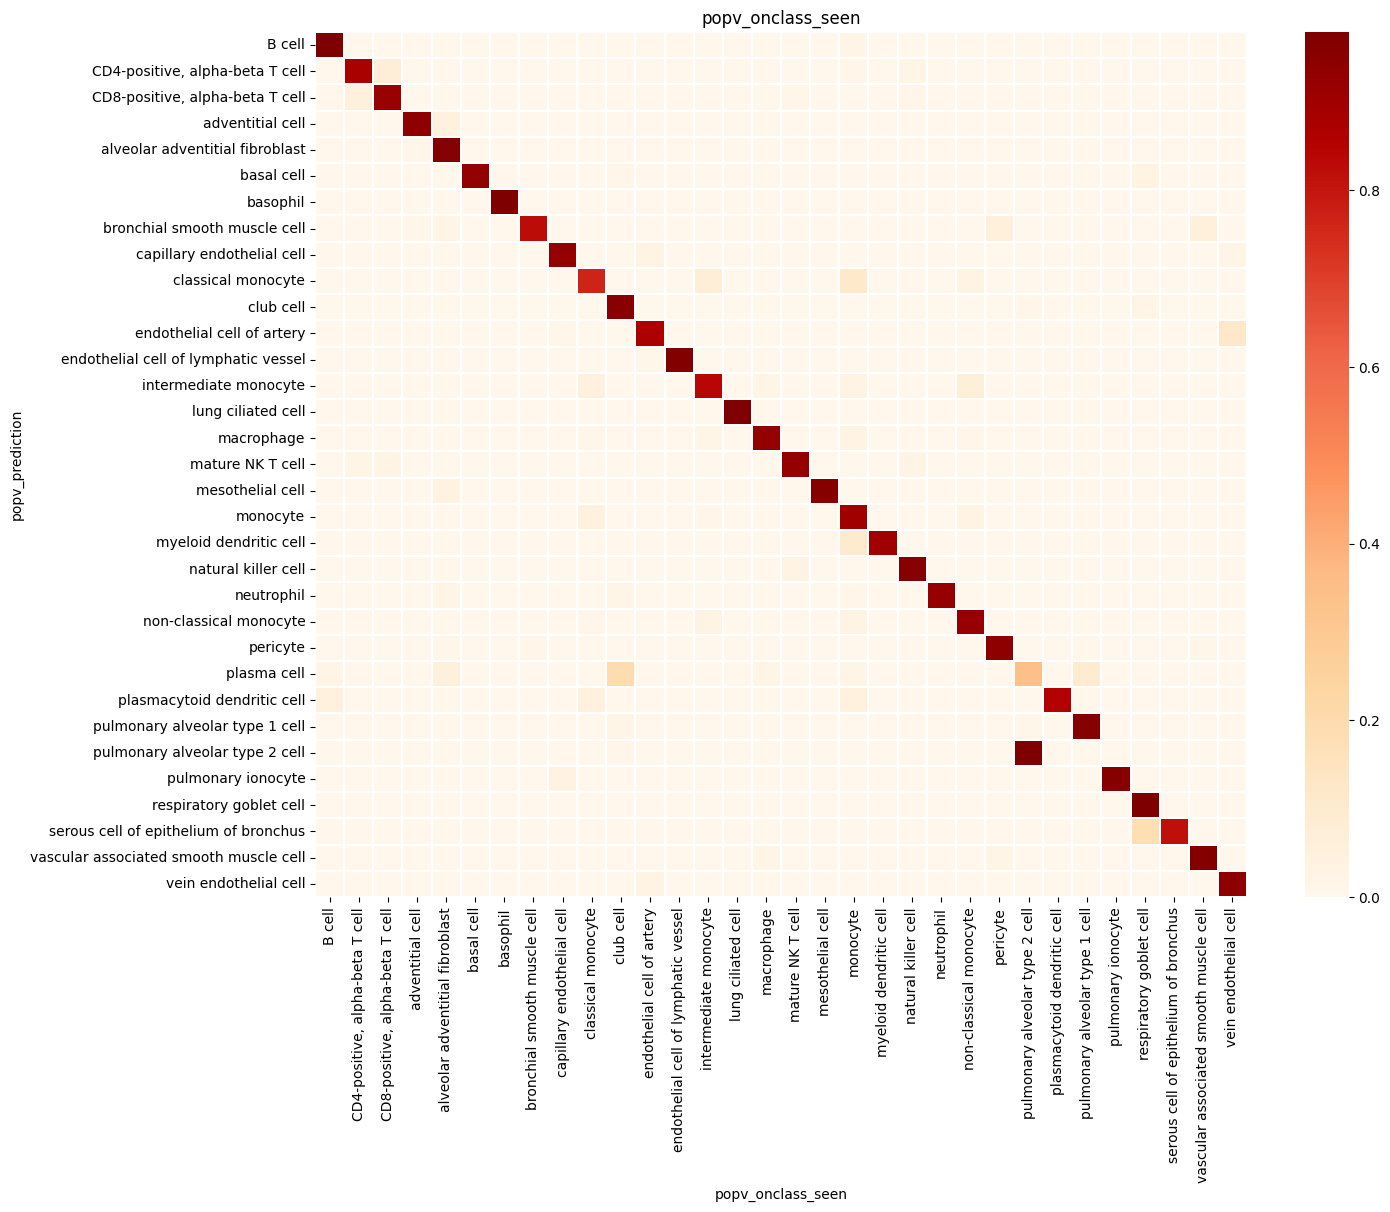

In [ ]:
popv.visualization.make_agreement_plots(
    adata,
    prediction_keys=adata.uns["prediction_keys"] + ["popv_onclass_seen"],
)

<Axes: title={'center': 'PopV Prediction Score'}, xlabel='Score', ylabel='Frequency'>

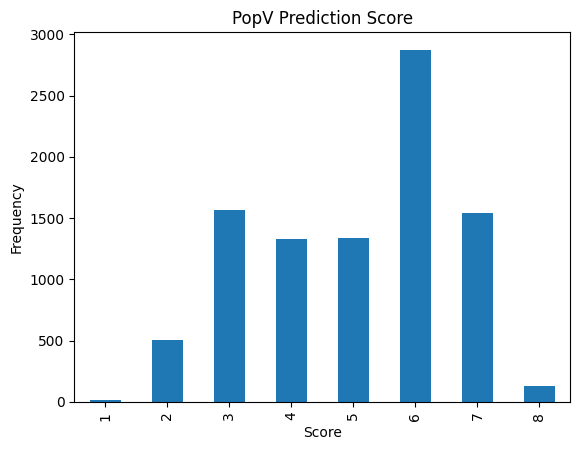

In [ ]:
popv.visualization.prediction_score_bar_plot(adata, popv_prediction_score="popv_prediction_score")

<Axes: ylabel='Mean Agreement'>

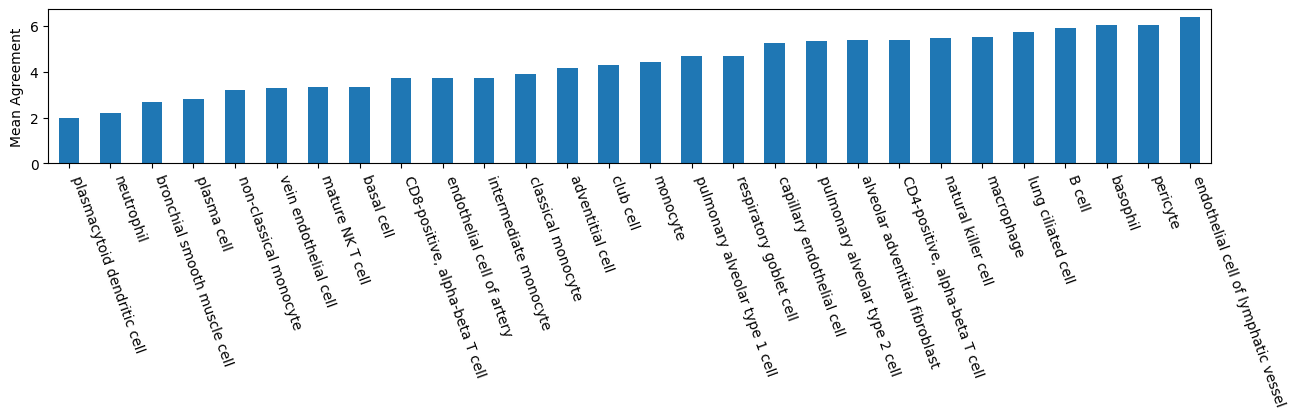

In [ ]:
popv.visualization.agreement_score_bar_plot(adata)

### Cell type proportion plot

<Axes: ylabel='Celltype Abundance'>

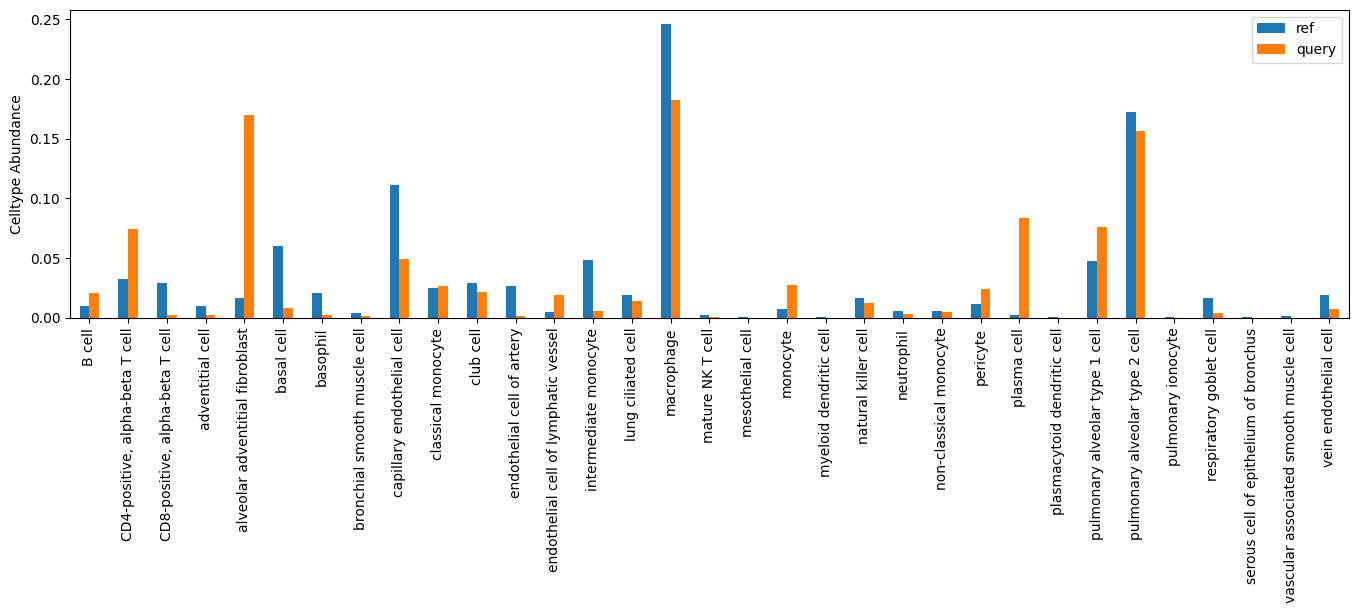

In [ ]:
popv.visualization.celltype_ratio_bar_plot(adata)